In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=3


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MaxAbsScaler
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

import keras
import keras.layers as ll
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.externals import joblib
from IPython.display import clear_output
%matplotlib inline

Using TensorFlow backend.
/home/tgaintseva/data/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
import tensorflow
tensorflow.__version__

'1.15.0'

In [4]:
tf_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True), log_device_placement=True)

In [5]:
data_all_pids = pd.read_csv("./data/data_for_gan_combined.csv").drop('Unnamed: 0', axis=1)

In [6]:
vars_list = list(data_all_pids)
vars_list_input, vars_list_aux, vars_list_MC = [], [], []

for v in vars_list:
    if v == 'pid': 
        vars_list_MC.append(v)
    elif 'aux' in v: 
        vars_list_aux.append(v)
    else: 
        vars_list_input.append(v)

In [8]:
in_columns = ['S0aux7', 'S0aux6', 'S3aux0', 'S2aux0', 'S5aux0']
out_columns = vars_list_input
IN_DIM = len(in_columns)
OUT_DIM = len(out_columns)
MODEL_NAME = "GAN_Kramer_pide"

In [9]:
BATCH_SIZE = int(1e4)
LATENT_DIMENSIONS = 3
TEST_SIZE = 0.3

In [10]:
def split_and_scale(data, robust_scaler=None, maxabs_scaler=None):
    data_train, data_val = train_test_split(data, test_size=TEST_SIZE, random_state=42)
    data_val, data_test = train_test_split(data_val, test_size=TEST_SIZE, random_state=1812)
    
    pid_train = np.array(data_train["pid"])
    pid_val = np.array(data_val["pid"])
    pid_test = np.array(data_test["pid"])
    
    data_train.drop("pid", axis=1, inplace=True)
    data_val.drop("pid", axis=1, inplace=True)
    data_test.drop("pid", axis=1, inplace=True)
    
    # applying robust scaler
    if robust_scaler is None:
        robust_scaler = RobustScaler().fit(data_train)
        joblib.dump(robust_scaler, os.path.join('gan_preprocessors', MODEL_NAME) + "_robust_preprocessor.pkl")
        
    data_train = pd.DataFrame(robust_scaler.transform(data_train.values),
                              columns=data_train.columns)
    data_val = pd.DataFrame(robust_scaler.transform(data_val.values),
                            columns=data_val.columns)
    data_test = pd.DataFrame(robust_scaler.transform(data_test.values),
                            columns=data_test.columns)
    
    # applying max abs scaler
    if maxabs_scaler is None:
        maxabs_scaler = MaxAbsScaler().fit(data_train)
        joblib.dump(maxabs_scaler, os.path.join('gan_preprocessors', MODEL_NAME) + "_maxabs_preprocessor.pkl")
        
    data_train = pd.DataFrame(maxabs_scaler.transform(data_train),
                              columns=data_train.columns)
    data_val = pd.DataFrame(maxabs_scaler.transform(data_val),
                            columns=data_val.columns)
    data_test = pd.DataFrame(maxabs_scaler.transform(data_test),
                            columns=data_test.columns)
    
    data_train["pid"] = pid_train
    data_val["pid"] = pid_val
    data_test["pid"] = pid_test
    
    return data_train, data_val, data_test, robust_scaler, max_abs_scaler

In [11]:
data_pid = data_all_pids[data_all_pids.pid == 'e']
try:
    robust_scaler = joblib.load(os.path.join('gan_preprocessors', MODEL_NAME) + "_robust_preprocessor.pkl") 
    max_abs_scaler = joblib.load(os.path.join('gan_preprocessors', MODEL_NAME) + "_maxabs_preprocessor.pkl")
except:
    print("ololo")
    robust_scaler, max_abs_scaler = None, None
data_train, data_val, data_test, robust_scaler, max_abs_scaler = split_and_scale(data_pid, robust_scaler, max_abs_scaler)
data_train.drop("pid", axis=1, inplace=True)
data_val.drop("pid", axis=1, inplace=True)

ololo


/home/tgaintseva/data/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [12]:
data_test.head()

,S5aux0,S3aux0,S2aux0,S0aux0,S0aux1,S0aux2,S0aux3,S2aux1,S2aux2,S2aux3,S0aux4,S0aux5,S0aux6,S0aux7,S0aux8,GS3x1,GS3x0,GS0x7,pid
0,0.0,0.0,0.0,0.025990,0.000000,-0.059434,-0.263158,0.0,0.0,0.0,0.009853,0.0,-0.365389,0.007047,0.081623,-0.169902,-0.359867,-0.006663,e
1,0.0,0.0,0.0,0.106751,0.000000,-0.040878,-0.157895,0.0,0.0,0.0,0.106538,0.0,0.013573,-0.018878,-0.026423,-0.211680,-0.647147,-0.003883,e
2,0.0,0.0,0.0,0.116046,-0.066667,0.044967,0.210526,0.0,0.0,0.0,0.078966,0.0,0.184930,0.080059,0.067828,-0.095021,-0.208689,-0.002425,e
3,0.0,0.0,0.0,-0.009855,-0.200000,0.057296,0.105263,0.0,0.0,0.0,0.431530,0.0,-0.039186,0.009472,0.021984,-0.293756,0.011469,-0.006856,e
4,0.0,0.0,0.0,0.046249,0.066667,-0.032254,0.105263,0.0,0.0,0.0,-0.007359,0.0,0.296460,0.216614,0.155450,-0.156970,-0.321744,0.560872,e


In [13]:
np.unique(data_test["S3aux0"], return_counts=True)

(array([-1.,  0.]), array([  250, 33109]))

In [14]:
aux_columns = vars_list_aux

In [15]:
np.array(aux_columns)

array(['S5aux0', 'S3aux0', 'S2aux0', 'S0aux0', 'S0aux1', 'S0aux2',
       'S0aux3', 'S2aux1', 'S2aux2', 'S2aux3', 'S0aux4', 'S0aux5',
       'S0aux6', 'S0aux7', 'S0aux8'], dtype='<U6')

Let's look at the distributions of the features:

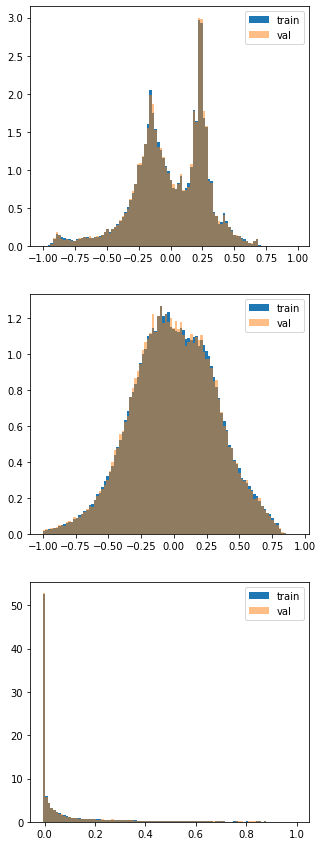

In [16]:
fig, axes = plt.subplots(3, 1, figsize=(5, 15))
for feature_name, ax in zip(vars_list_input, axes):
    _, bins, _ = ax.hist(data_train[feature_name].values, bins=100, label="train", density=True)
    ax.hist(data_val[feature_name].values, bins=bins, label="val", alpha=0.5, density=True)
    ax.legend()
plt.show()

## Building GAN

In [17]:
data_train = data_train[in_columns+out_columns]
data_val = data_val[in_columns+out_columns]

data_test = data_test[in_columns+out_columns]

In [46]:
data_test.to_csv("./data/test.csv")

In [18]:
def get_tf_dataset(dataset, batch_size):
    shuffler = tf.contrib.data.shuffle_and_repeat(dataset.shape[0])
    shuffled_ds = shuffler(tf.data.Dataset.from_tensor_slices(dataset))
    return tf.compat.v1.data.make_one_shot_iterator(shuffled_ds.batch(batch_size).prefetch(1)).get_next()
#       shuffled_ds = tf.data.Dataset.from_tensor_slices(dataset.values).shuffle(dataset.shape[0], reshuffle_each_iteration=True).repeat()
#       return tf.compat.v1.data.make_one_shot_iterator(shuffled_ds.batch(batch_size).prefetch(1)).get_next()

In [19]:
tf.reset_default_graph()

In [20]:
tf.compat.v1.disable_eager_execution()
def get_dense(num_layers):
    return [ll.Dense(80, activation='relu') for i in range(num_layers)]

CRAMER_DIM = 150

critic = keras.models.Sequential(
        [ll.InputLayer([OUT_DIM + IN_DIM])] + get_dense(3) +
            [ll.Dense(CRAMER_DIM)])
generator = keras.models.Sequential(
        [ll.InputLayer([LATENT_DIMENSIONS + IN_DIM])] + get_dense(3) +
            [ll.Dense(OUT_DIM)])

In [21]:
X_train_full = data_train[in_columns+out_columns]
X_train_input = data_train[in_columns]

X_train_input_tf1 = get_tf_dataset(X_train_input, BATCH_SIZE)
X_train_input_tf2 = get_tf_dataset(X_train_input, BATCH_SIZE)
X_train_full_tf = get_tf_dataset(X_train_full, BATCH_SIZE)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use `tf.data.experimental.shuffle_and_repeat(...)`.
Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizations will take care of using the fused implementation.


In [22]:
def cramer_critic(x, y):
    discriminated_x = critic(x)
    return tf.norm(discriminated_x - critic(y), axis=1) - tf.norm(discriminated_x, axis=1)

In [23]:
noise_1 = tf.random_normal([tf.shape(X_train_input_tf1)[0], LATENT_DIMENSIONS], name='noise1')
noise_2 = tf.random_normal([tf.shape(X_train_input_tf2)[0], LATENT_DIMENSIONS], name='noise2')

generated_out_1 = generator(tf.concat([noise_1, tf.cast(X_train_input_tf1, tf.float32)], axis=1))
generated_full_1 = tf.concat([tf.cast(X_train_input_tf1, tf.float32), generated_out_1], axis=1)

generated_out_2 = generator(tf.concat([noise_2, tf.cast(X_train_input_tf2, tf.float32)], axis=1))
generated_full_2 = tf.concat([tf.cast(X_train_input_tf2, tf.float32), generated_out_2], axis=1)

In [24]:
generator_loss = tf.reduce_mean(cramer_critic(tf.cast(X_train_full_tf, tf.float32), generated_full_2)
                                - cramer_critic(generated_full_1, generated_full_2))

In [25]:
with tf.name_scope("gradient_loss"):
    alpha = tf.random_uniform(shape=[tf.shape(X_train_full_tf)[0], 1], minval=0., maxval=1.)
    interpolates = alpha*tf.cast(X_train_full_tf, tf.float32) + (1.-alpha)*generated_full_1
    disc_interpolates = cramer_critic(interpolates, generated_full_2)
    gradients = tf.gradients(disc_interpolates, [interpolates])[0]
    slopes = tf.norm(tf.reshape(gradients, [tf.shape(gradients)[0], -1]), axis=1)
    gradient_penalty = tf.reduce_mean(tf.square(tf.maximum(tf.abs(slopes) - 1, 0)))

In [26]:
tf_iter = tf.Variable(initial_value=0, dtype=tf.int32)
lambda_tf = 20 / np.pi * 2 * tf.atan(tf.cast(tf_iter, tf.float32)/1e4)
critic_loss = lambda_tf*gradient_penalty - generator_loss
learning_rate = tf.train.exponential_decay(5e-4, tf_iter, 100, 0.99)
optimizer = tf.train.RMSPropOptimizer(learning_rate)
critic_train_op = optimizer.minimize(critic_loss, var_list=critic.trainable_weights)
generator_train_op = tf.group(
    optimizer.minimize(generator_loss, var_list=generator.trainable_weights),
    tf.assign_add(tf_iter, 1))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [27]:
tf.summary.scalar("critic_loss", tf.reshape(critic_loss, []))
tf.summary.scalar("generator_loss", tf.reshape(generator_loss, []))
tf.summary.scalar("learning_rate", learning_rate)
tf.summary.scalar("lambda", lambda_tf)
merged_summary = tf.summary.merge_all()

In [28]:
len(data_val)

77836

In [29]:
N_VAL = int(5e4)
validation_np = data_val.sample(N_VAL).values

In [30]:
data_val.sample(N_VAL).head()

,S0aux7,S0aux6,S3aux0,S2aux0,S5aux0,GS3x1,GS3x0,GS0x7
68983,0.001666,0.582142,0.0,0.0,0.0,-0.594812,-0.397095,-0.006747
40607,-0.001055,0.252782,0.0,0.0,0.0,-0.195382,-0.562531,0.206584
76602,-0.005283,-0.209463,0.0,0.0,0.0,0.282521,0.579739,-0.006810
28329,-0.025379,-0.178764,0.0,0.0,0.0,0.178988,0.318673,0.138879
59153,-0.010898,0.237548,0.0,0.0,0.0,-0.415655,-0.161435,0.749705


In [31]:
np.unique(data_val["S3aux0"])

array([-1.,  0.])

In [32]:
var_init = tf.global_variables_initializer()
weights_saver = tf.train.Saver()

In [33]:
tf.get_default_graph().finalize()

## Training GAN

In [34]:
LOGDIR = "./tensorboard_logdir"
CRITIC_ITERATIONS_CONST = 15
CRITIC_ITERATIONS_VAR = 0
TOTAL_ITERATIONS = int(2e5)
VALIDATION_INTERVAL = 100
MODEL_WEIGHTS_FILE = "./weights/%s.ckpt" % MODEL_NAME
train_writer = tf.summary.FileWriter(os.path.join(LOGDIR, MODEL_NAME, "train"))
test_writer = tf.summary.FileWriter(os.path.join(LOGDIR, MODEL_NAME, "test"))
critic_policy = lambda i: (
    CRITIC_ITERATIONS_CONST + (CRITIC_ITERATIONS_VAR * (TOTAL_ITERATIONS - i)) // TOTAL_ITERATIONS)

In [35]:
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 80)                720       
_________________________________________________________________
dense_6 (Dense)              (None, 80)                6480      
_________________________________________________________________
dense_7 (Dense)              (None, 80)                6480      
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 243       
Total params: 13,923
Trainable params: 13,923
Non-trainable params: 0
_________________________________________________________________


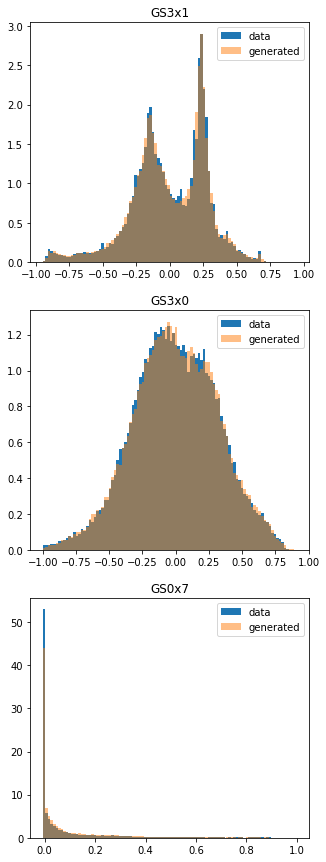

KeyboardInterrupt: 

In [36]:
with tf.Session(config=tf_config) as sess:
    sess.run(var_init)
    try:
        weights_saver.restore(sess, MODEL_WEIGHTS_FILE)
    except Exception as e:
        print("Can't restore parameters: no file with weights")
        print(e)
    for i in range(TOTAL_ITERATIONS):
        for j in range(critic_policy(i)):
            sess.run(critic_train_op)
        train_summary, _, interation = sess.run([merged_summary, generator_train_op, tf_iter])
        train_writer.add_summary(train_summary, interation)
        if i % VALIDATION_INTERVAL == 0:
            clear_output(False)
            test_summary, test_generated = sess.run([merged_summary, generated_out_1], {
                X_train_input_tf1: validation_np[:, :len(in_columns)],
                X_train_input_tf2: validation_np[:, :len(in_columns)], X_train_full_tf: validation_np})
            try:
                fig, axes = plt.subplots(3, 1, figsize=(5, 3*5))
                for INDEX, ax in zip((0, 1, 2), axes):
                    _, bins, _ = ax.hist(validation_np[:, INDEX+len(in_columns)], bins=100, label="data", density=True)
                    ax.hist(test_generated[:, INDEX], bins=bins, label="generated", alpha=0.5, density=True)
                    ax.legend()
                    ax.set_title(out_columns[INDEX])
                plt.show()
                fig.savefig('./plots/{}.png'.format(MODEL_NAME))
            except Exception as e:
                print(e)
                weights_saver.restore(sess, MODEL_WEIGHTS_FILE)
                continue
            
            test_writer.add_summary(test_summary, interation)
            weights_saver.save(sess, MODEL_WEIGHTS_FILE)

Look at the result distributions:

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla K80, pci bus id: efc8:00:00.0, compute capability: 3.7

INFO:tensorflow:Restoring parameters from ./weights/GAN_Kramer_pide.ckpt


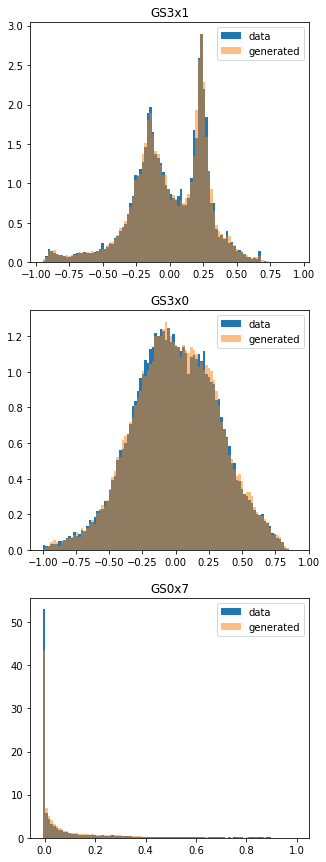

In [37]:
with tf.Session(config=tf_config) as sess:
    sess.run(var_init)
    try:
        weights_saver.restore(sess, MODEL_WEIGHTS_FILE)
    except tf.errors.NotFoundError:
        print("Can't restore parameters: no file with weights")
    test_summary, test_generated = sess.run([merged_summary, generated_out_1], {
        X_train_input_tf1: data_test.values[:, :len(in_columns)],
        X_train_input_tf2: data_test.values[:, :len(in_columns)], X_train_full_tf: data_test})
    fig, axes = plt.subplots(3, 1, figsize=(5, 15))
    for INDEX, ax in zip((0, 1, 2), axes):
        _, bins, _ = ax.hist(validation_np[:, INDEX+len(in_columns)], bins=100, label="data", density=True)
        ax.hist(test_generated[:, INDEX], bins=bins, label="generated", alpha=0.5, density=True)
        ax.legend()
        ax.set_title(out_columns[INDEX])
    plt.show()

In [47]:
# save weights to pkl format
import pickle
with tf.Session(config=tf_config) as sess:
    sess.run(var_init)
    weights_saver.restore(sess, MODEL_WEIGHTS_FILE)
    weights = sess.run(generator.weights)
    output = open('./weights/{}.pkl'.format(MODEL_NAME), 'wb')
    pickle.dump(weights, output)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla K80, pci bus id: efc8:00:00.0, compute capability: 3.7

INFO:tensorflow:Restoring parameters from ./weights/GAN_Kramer_pide.ckpt


In [38]:
robust_scaler = joblib.load(os.path.join('gan_preprocessors', MODEL_NAME) + "_robust_preprocessor.pkl") 
max_abs_scaler = joblib.load(os.path.join('gan_preprocessors', MODEL_NAME) + "_maxabs_preprocessor.pkl")

In [39]:
test_transformed = max_abs_scaler.inverse_transform(np.concatenate([data_pid[vars_list_aux][:len(test_generated)].values, test_generated], axis=1))
test_transformed = robust_scaler.inverse_transform(test_transformed)
df_temp_enc = pd.DataFrame(test_transformed[:, -len(out_columns):], columns=out_columns)
df_temp_full_enc = pd.DataFrame(np.concatenate([df_temp_enc, data_test[['S0aux7', 'S0aux6', 'S3aux0', 'S2aux0', 'S5aux0']]], axis=1), columns=out_columns+['S0aux7', 'S0aux6', 'S3aux0', 'S2aux0', 'S5aux0'])
df_temp_full_enc['pid'] = ['e']*len(df_temp_full_enc)
df_temp_full_enc.to_csv("./data/generated_pid{}.csv".format(MODEL_NAME), index=None)

## %%%%%%%%%%%%%%%%

Passing xgb encoded test data through gan

In [29]:
xgb_test_encoded = pd.read_csv('./data/ae_encoded_test_pid_{}_old.csv'.format(3))
xgb_test_encoded = xgb_test_encoded[xgb_test_encoded.pid==0]
y_test_dec = xgb_test_encoded["pid"].values
xgb_test_encoded = xgb_test_encoded.drop(["pid", "Unnamed: 0"], axis=1)

In [33]:
scaler = joblib.load(os.path.join('preprocessors', MODEL_NAME) + "_preprocessor.pkl") 
xgb_test_encoded = pd.DataFrame(scaler.transform(xgb_test_encoded.values),
                            columns=xgb_test_encoded.columns)

INFO:tensorflow:Restoring parameters from weights/GAN_Kramer_dim3_bs1e4_n80-150_old_pida.ckpt


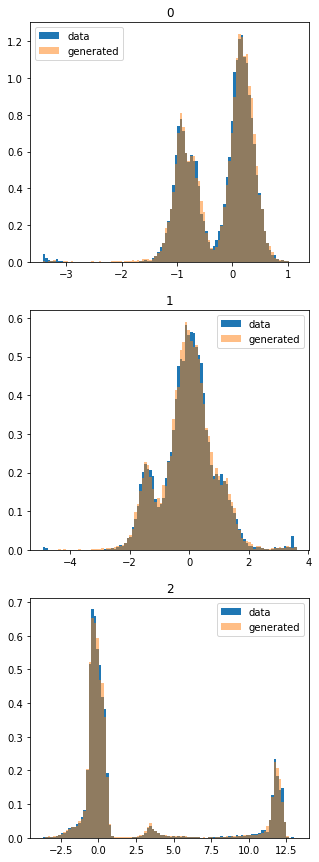

In [34]:
with tf.Session(config=tf_config) as sess:
    sess.run(var_init)
    try:
        weights_saver.restore(sess, MODEL_WEIGHTS_FILE)
    except tf.errors.NotFoundError:
        print("Can't restore parameters: no file with weights")
    test_summary, test_generated = sess.run([merged_summary, generated_out_1], {
        X_train_input_tf1: xgb_test_encoded[in_columns].values,
        X_train_input_tf2: xgb_test_encoded[in_columns].values, X_train_full_tf: xgb_test_encoded[in_columns+['0', '1', '2']]})
    fig, axes = plt.subplots(3, 1, figsize=(5, 15))
    for INDEX, ax in zip((0, 1, 2), axes):
        _, bins, _ = ax.hist(xgb_test_encoded[str(INDEX)].values, bins=100, label="data", density=True)
        ax.hist(test_generated[:, INDEX], bins=bins, label="generated", alpha=0.5, density=True)
        ax.legend()
        ax.set_title(out_columns[INDEX])
    plt.show()

In [45]:
np.concatenate([test_generated, xgb_test_encoded[aux_columns].values], axis=1).shape

(16361, 18)

In [49]:
test_transformed = scaler.inverse_transform(np.concatenate([test_generated, xgb_test_encoded[aux_columns].values], axis=1))
df_temp_enc = pd.DataFrame(test_transformed, columns=out_columns+aux_columns)
df_temp_enc['pid'] = ['a']*len(df_temp_enc)
df_temp_enc.to_csv("./data/AE_GAN_TEST_{}.csv".format(MODEL_NAME), index=None)

In [48]:
df_temp_enc.head()

,0,1,2,S5aux0,S3aux0,S2aux0,S0aux0,S0aux1,S0aux2,S0aux3,S2aux1,S2aux2,S2aux3,S0aux4,S0aux5,S0aux6,S0aux7,S0aux8,pid
0,0.467792,0.087461,-0.496493,0.284772,0.223544,0.259309,-0.023609,0.151479,-0.100290,-0.130448,0.259122,0.259099,0.25913,-0.330167,0.0,-0.261844,-0.000425,-0.000056,a
1,0.407129,0.153227,-0.459095,0.284772,0.223544,0.259309,-0.110724,0.080769,-0.044189,-0.063951,0.259122,0.259099,0.25913,-0.466117,0.0,0.142402,-0.000153,-0.000412,a
2,0.399416,0.040694,-0.065042,0.284772,0.223544,0.259309,-0.184076,-0.697042,0.073549,0.534522,0.259122,0.259099,0.25913,-0.326070,0.0,0.002182,-0.000322,-0.000368,a
3,0.106759,0.006603,0.771652,0.284772,-1.000000,-1.000000,0.065298,0.363609,0.191085,0.069043,-1.000000,-1.000000,-1.00000,-0.058140,0.0,-0.144016,-0.000380,-0.000207,a
4,0.068912,-0.148423,0.828838,0.284772,-1.000000,-1.000000,0.087397,-0.060651,0.120089,0.135540,-1.000000,-1.000000,-1.00000,0.050400,0.0,-0.086502,-0.000401,-0.000360,a
